# I. Introduction

![Simulated Annealing](SA_animation.gif)
As illustrated in the lectures, simulated annealing is a probablistic technique used for finding an approximate solution to an optimization problem.  In this exercise you will check your understanding by implementing [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) to solve the [Traveling Salesman Problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) (TSP) between US state capitals.  Briefly, the TSP is an optimization problem that seeks to find the shortest path passing through every city exactly once.  In our example the TSP path is defined to start and end in the same city (so the path is a closed loop).

Image Source: [Simulated Annealing - By Kingpin13 (Own work) [CC0], via Wikimedia Commons (Attribution not required)](https://commons.wikimedia.org/wiki/File:Hill_Climbing_with_Simulated_Annealing.gif)

## Overview

  0. Implement the `simulated_annealing()` main loop function in Section II
  0. Complete the `TravelingSalesmanProblem` class by implementing the `successors()` and `get_value()` methods in section III
  0. Complete the `schedule()` function to define the temperature schedule in Section IV
  0. Use the completed algorithm and problem description to experiment with simulated annealing to solve larger TSP instances on the map of US capitals

In [1]:
import json
import copy

import numpy as np  # contains helpful math functions like numpy.exp()
import numpy.random as random  # see numpy.random module
# import random  # alternative to numpy.random module

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
"""Read input data and define helper functions for visualization."""

# Map services and data available from U.S. Geological Survey, National Geospatial Program.
# Please go to http://www.usgs.gov/visual-id/credit_usgs.html for further information
map = mpimg.imread("map.png")  # US States & Capitals map

# List of 30 US state capitals and corresponding coordinates on the map
with open('capitals.json', 'r') as capitals_file:
    capitals = json.load(capitals_file)
capitals_list = list(capitals.items())

def show_path(path, starting_city, w=12, h=8):
    """Plot a TSP path overlaid on a map of the US States & their capitals."""
    x, y = list(zip(*path))
    _, (x0, y0) = starting_city
    plt.imshow(map)
    plt.plot(x0, y0, 'y*', markersize=15)  # y* = yellow star for starting point
    plt.plot(x + x[:1], y + y[:1])  # include the starting point at the end of path
    plt.axis("off")
    fig = plt.gcf()
    fig.set_size_inches([w, h])

In [3]:
capitals_list

[('Oklahoma City', [392.8, 356.4]),
 ('Montgomery', [559.6, 404.8]),
 ('Saint Paul', [451.6, 186.0]),
 ('Trenton', [698.8, 239.6]),
 ('Salt Lake City', [204.0, 243.2]),
 ('Columbus', [590.8, 263.2]),
 ('Austin', [389.2, 448.4]),
 ('Phoenix', [179.6, 371.2]),
 ('Hartford', [719.6, 205.2]),
 ('Baton Rouge', [489.6, 442.0]),
 ('Salem', [80.0, 139.2]),
 ('Little Rock', [469.2, 367.2]),
 ('Richmond', [673.2, 293.6]),
 ('Jackson', [501.6, 409.6]),
 ('Des Moines', [447.6, 246.0]),
 ('Lansing', [563.6, 216.4]),
 ('Denver', [293.6, 274.0]),
 ('Boise', [159.6, 182.8]),
 ('Raleigh', [662.0, 328.8]),
 ('Atlanta', [585.6, 376.8]),
 ('Madison', [500.8, 217.6]),
 ('Indianapolis', [548.0, 272.8]),
 ('Nashville', [546.4, 336.8]),
 ('Columbia', [632.4, 364.8]),
 ('Providence', [735.2, 201.2]),
 ('Boston', [738.4, 190.8]),
 ('Tallahassee', [594.8, 434.8]),
 ('Sacramento', [68.4, 254.0]),
 ('Albany', [702.0, 193.6]),
 ('Harrisburg', [670.8, 244.0])]

## II. Simulated Annealing -- Main Loop

The main loop of simulated annealing repeatedly generates successors in the neighborhood of the current state and considers moving there according to an acceptance probability distribution parameterized by a cooling schedule.  See the [simulated-annealing function](https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md) pseudocode from the AIMA textbook online at github.  Note that our Problem class is already a "node", so the MAKE-NODE line is not required.

In [31]:
def simulated_annealing(problem, schedule):
    """The simulated annealing algorithm, a version of stochastic hill climbing
    where some downhill moves are allowed. Downhill moves are accepted readily
    early in the annealing schedule and then less often as time goes on. The
    schedule input determines the value of the temperature T as a function of
    time. [Norvig, AIMA Chapter 3]
    
    Parameters
    ----------
    problem : Problem
        An optimization problem, already initialized to a random starting state.
        The Problem class interface must implement a callable method
        "successors()" which returns states in the neighborhood of the current
        state, and a callable function "get_value()" which returns a fitness
        score for the state. (See the `TravelingSalesmanProblem` class below
        for details.)

    schedule : callable
        A function mapping time to "temperature". "Time" is equivalent in this
        case to the number of loop iterations.
    
    Returns
    -------
    Problem
        An approximate solution state of the optimization problem
        
    Notes
    -----
        (1) DO NOT include the MAKE-NODE line from the AIMA pseudocode

        (2) Modify the termination condition to return when the temperature
        falls below some reasonable minimum value (e.g., 1e-10) rather than
        testing for exact equality to zero
        
    See Also
    --------
    AIMA simulated_annealing() pseudocode
        https://github.com/aimacode/aima-pseudocode/blob/master/md/Simulated-Annealing.md
    """     
    current = problem #already initialized to a random starting state
    delta = 1e-10
    t = 1
    while True:
        T = schedule(t)
        if T < delta: return current
        # randonly selected successor of current
        successors = current.successors() # use different successors function
        i = random.randint(len(successors))
        next_node = successors[i]
        diff = next_node.get_value() - current.get_value()
        if diff > 0: current = next_node
        else:
            prob = np.exp(1.*diff/T)
            if prob > random.random(): # certain probability of using
                current = next_node
            else:
                current = current
        t += 1

## III. Representing the Problem

In order to use simulated annealing we need to build a representation of the problem domain.  The choice of representation can have a significant impact on the performance of simulated annealing and other optimization techniques.  Since the TSP deals with a close loop that visits each city in a list once, we will represent each city by a tuple containing the city name and its position specified by an (x,y) location on a grid.  The _state_ will then consist of an ordered sequence (a list) of the cities; the path is defined as the sequence generated by traveling from each city in the list to the next in order.

In [9]:
def euclidean_distance(start, end):
    sx, sy = start
    ex, ey = end
    return np.sqrt((ex - sx)**2 + (ey - sy)**2)

def manhattan_distance(start, end):
    sx, sy = start
    ex, ey = end
    return abs(ex - sx) + abs(ey - sy)

In [55]:
class TravelingSalesmanProblem:
    """Representation of a traveling salesman optimization problem.  The goal
    is to find the shortest path that visits every city in a closed loop path.
    
    Students should only need to implement or modify the successors() and
    get_values() methods.
    
    Parameters
    ----------
    cities : list
        A list of cities specified by a tuple containing the name and the x, y
        location of the city on a grid. e.g., ("Atlanta", (585.6, 376.8))
    
    Attributes
    ----------
    names
    coords
    path : list
        The current path between cities as specified by the order of the city
        tuples in the list.
    """
    def __init__(self, cities):
        self.path = copy.deepcopy(cities)
    
    def copy(self):
        """Return a copy of the current board state."""
        new_tsp = TravelingSalesmanProblem(self.path)
        return new_tsp
    
    @property
    def names(self):
        """Strip and return only the city name from each element of the
        path list. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> ["Atlanta", ...]
        """
        names, _ = zip(*self.path)
        return names
    
    @property
    def coords(self):
        """Strip the city name from each element of the path list and return
        a list of tuples containing only pairs of xy coordinates for the
        cities. For example,
            [("Atlanta", (585.6, 376.8)), ...] -> [(585.6, 376.8), ...]
        """
        _, coords = zip(*self.path)
        return coords
    
    def successors(self):
        """Return a list of states in the neighborhood of the current state by
        switching the order in which any adjacent pair of cities is visited.
        
        For example, if the current list of cities (i.e., the path) is [A, B, C, D]
        then the neighbors will include [A, B, D, C], [A, C, B, D], [B, A, C, D],
        and [D, B, C, A]. (The order of successors does not matter.)
        
        In general, a path of N cities will have N neighbors (note that path wraps
        around the end of the list between the first and last cities).

        Returns
        -------
        list<Problem>
            A list of TravelingSalesmanProblem instances initialized with their list
            of cities set to one of the neighboring permutations of cities in the
            present state
        """
        path = self.path
        N = len(path)
        if N < 2: return self
        result = []
        for i in range(N-1): 
            # self.path is a tuple, iterate path
            new_tsp = self.copy()
            new_path = new_tsp.path
            new_path[i],new_path[i+1] = new_path[i+1],new_path[i]
            new_tsp = TravelingSalesmanProblem(new_path)
            result.append(new_tsp)
            # can also switch first with last
        if N > 2: 
            new_tsp = self.copy()
            new_path = new_tsp.path
            new_path[0],new_path[-1] = new_path[-1],new_path[0]
            new_tsp = TravelingSalesmanProblem(new_path)
            result.append(new_tsp)
        return result
    
    def any_successors(self):
        """Return a list of states in the neighborhood of the current state by
        switching the order in which any pair of cities is visited.
        
        For example, if the current list of cities (i.e., the path) is [A, B, C, D]
        then the neighbors will include [A, B, D, C], [A, C, B, D], [B, A, C, D],
        and [D, B, C, A]. (The order of successors does not matter.)

        Returns
        -------
        list<Problem>
            A list of TravelingSalesmanProblem instances initialized with their list
            of cities set to one of the permutations of cities in the
            present state
        """
        path = self.path
        N = len(path)
        if N < 2: return self
        result = []
        for i in range(N-1): 
            for j in range(i+1,N):
                new_tsp = self.copy()
                new_path = new_tsp.path
                new_path[i],new_path[j] = new_path[j],new_path[i]
                new_tsp = TravelingSalesmanProblem(new_path)
                result.append(new_tsp)
            # can also switch first with last
        return result
        

    def get_value(self):
        """Calculate the total length of the closed-circuit path of the current
        state by summing the distance between every pair of adjacent cities.  Since
        the default simulated annealing algorithm seeks to maximize the objective
        function, return -1x the path length. (Multiplying by -1 makes the smallest
        path the smallest negative number, which is the maximum value.)
        
        Returns
        -------
        float
            A floating point value with the total cost of the path given by visiting
            the cities in the order according to the self.cities list
        
        Notes
        -----
            (1) Remember to include the edge from the last city back to the
            first city
            
            (2) Remember to multiply the path length by -1 so that simulated
            annealing finds the shortest path
        """
        path = self.path
        N = len(path)
        if N < 2: return 0.0 # no path available
        value = 0.0
        for i in range(N-1): # get distance of L^2 form
            c1 = self.coords[i]  # properties not with (), just call by itself
            c2 = self.coords[i+1]
            distance = euclidean_distance(c1,c2) # square root, use ** not ^
            value += distance
        # can also switch first with last
        if N > 2:
            c1 = self.coords[0] 
            c2 = self.coords[-1]
            distance = euclidean_distance(c1,c2)
            value += distance
        return -1.*value

### Testing TravelingSalesmanProblem
The following tests should validate the class constructor and functionality of the `successors()` and `get_value()` methods.

In [11]:
# Construct an instance of the TravelingSalesmanProblem
test_cities = [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
tsp = TravelingSalesmanProblem(test_cities)
assert(tsp.path == test_cities)

In [12]:
# Test the successors() method -- no output means the test passed
successor_paths = [x.path for x in tsp.successors()]
assert(all(x in [[('LA', (0, -4)), ('SF', (0, 0)), ('PHX', (2, -3)), ('DC', (11, 1))],
                 [('SF', (0, 0)), ('DC', (11, 1)), ('PHX', (2, -3)), ('LA', (0, -4))],
                 [('DC', (11, 1)), ('PHX', (2, -3)), ('SF', (0, 0)), ('LA', (0, -4))],
                 [('DC', (11, 1)), ('SF', (0, 0)), ('LA', (0, -4)), ('PHX', (2, -3))]]
          for x in successor_paths))

In [13]:
# Test the get_value() method -- no output means the test passed
assert(np.allclose(tsp.get_value(), -28.97, atol=1e-3))

## IV. Define the Temperature Schedule

The most common temperature schedule is simple exponential decay:
$T(t) = \alpha^t T_0$

(Note that this is equivalent to the incremental form $T_{i+1} = \alpha T_i$, but implementing that form is slightly more complicated because you need to preserve state between calls.)

In most cases, the valid range for temperature $T_0$ can be very high (e.g., 1e8 or higher), and the _decay parameter_ $\alpha$ should be close to, but less than 1.0 (e.g., 0.95 or 0.99).  Think about the ways these parameters effect the simulated annealing function.  Try experimenting with both parameters to see how it changes runtime and the quality of solutions.

You can also experiment with other schedule functions -- linear, quadratic, etc.  Think about the ways that changing the form of the temperature schedule changes the behavior and results of the simulated annealing function.

In [14]:
# These are presented as globals so that the signature of schedule()
# matches what is shown in the AIMA textbook; you could alternatively
# define them within the schedule function, use a closure to limit
# their scope, or define an object if you would prefer not to use
# global variables
alpha = 0.95
temperature=1e4

def schedule(time):
    return temperature * np.power(alpha,time)

### Testing the Temperature Schedule
The following tests should validate the temperature schedule function and perform a simple test of the simulated annealing function to solve a small TSP test case

In [15]:
# test the schedule() function -- no output means that the tests passed
assert(np.allclose(alpha, 0.95, atol=1e-3))
assert(np.allclose(schedule(0), temperature, atol=1e-3))
assert(np.allclose(schedule(10), 5987.3694, atol=1e-3))

In [16]:
# Failure implies that the initial path of the test case has been changed
assert(tsp.path == [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))])
result = simulated_annealing(tsp, schedule)
print("Initial score: {}\nStarting Path: {!s}".format(tsp.get_value(), tsp.path))
print("Final score: {}\nFinal Path: {!s}".format(result.get_value(), result.path))
assert(tsp.path != result.path)
assert(result.get_value() > tsp.get_value())

Initial score: -28.970026243745615
Starting Path: [('DC', (11, 1)), ('SF', (0, 0)), ('PHX', (2, -3)), ('LA', (0, -4))]
Final score: -27.130286796483155
Final Path: [('SF', (0, 0)), ('LA', (0, -4)), ('PHX', (2, -3)), ('DC', (11, 1))]


## V. Run Simulated Annealing on a Larger TSP
Now we are ready to solve a TSP on a bigger problem instance by finding a shortest-path circuit through several of the US state capitals.

Initial path value: 3074.15
[('Oklahoma City', [392.8, 356.4]), ('Montgomery', [559.6, 404.8]), ('Saint Paul', [451.6, 186.0]), ('Trenton', [698.8, 239.6]), ('Salt Lake City', [204.0, 243.2]), ('Columbus', [590.8, 263.2]), ('Austin', [389.2, 448.4]), ('Phoenix', [179.6, 371.2]), ('Hartford', [719.6, 205.2]), ('Baton Rouge', [489.6, 442.0])]


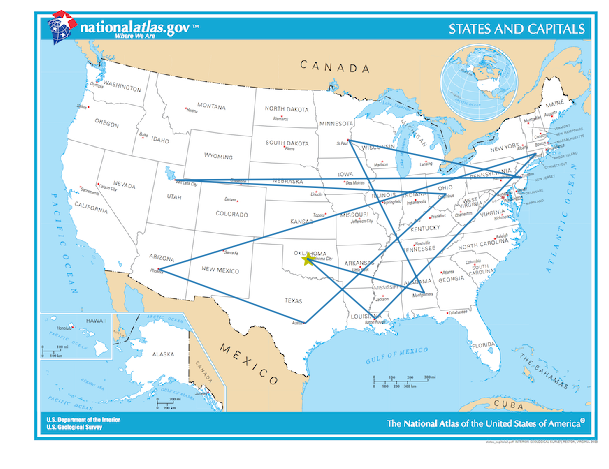

In [63]:
# Create the problem instance and plot the initial state
num_cities = 10
capitals_tsp = TravelingSalesmanProblem(capitals_list[:num_cities])
starting_city = capitals_list[0]
print("Initial path value: {:.2f}".format(-capitals_tsp.get_value()))
print(capitals_list[:num_cities])  # The start/end point is indicated with a yellow star
show_path(capitals_tsp.coords, starting_city)

In [64]:
import time

Running time is  1.65016508102417
Final path length: 1426.74
[('Saint Paul', [451.6, 186.0]), ('Salt Lake City', [204.0, 243.2]), ('Phoenix', [179.6, 371.2]), ('Oklahoma City', [392.8, 356.4]), ('Austin', [389.2, 448.4]), ('Baton Rouge', [489.6, 442.0]), ('Montgomery', [559.6, 404.8]), ('Trenton', [698.8, 239.6]), ('Hartford', [719.6, 205.2]), ('Columbus', [590.8, 263.2])]


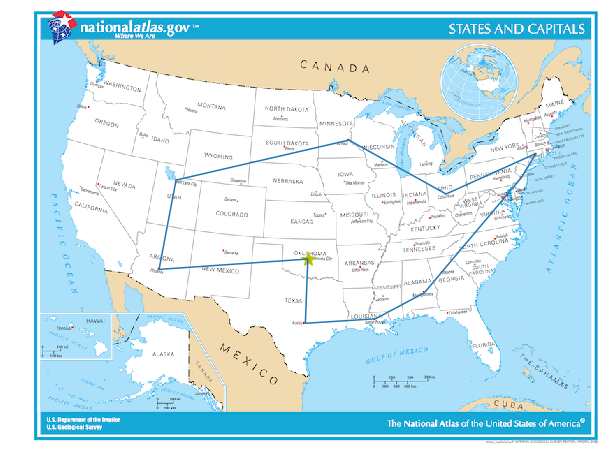

In [88]:
# set the decay rate and initial temperature parameters, then run simulated annealing to solve the TSP
alpha = 0.95
temperature=1e6
t0 = time.time()
result = simulated_annealing(capitals_tsp, schedule)
t1 = time.time() - t0
print ("Running time is ", t1)
print("Final path length: {:.2f}".format(-result.get_value()))
print(result.path)
show_path(result.coords, starting_city)

### Experiments

#### 1. Run the solver repeatedly -- how stable are the results?

- n = 10, alpha = 0.95, temperature=1e6
- Initial path value: 3074.15
- Final path length (average): 
- Run the experiment for N = 100 times to get the distribution of the path value
    - average path is 1822
    - path ranges from 1434 to 2507
    - compare with initial path of 3074.15, the solver improves the path
- The results are not stable, and shortest path is not always found. 

In [36]:
path_lengths = []
for i in range(20):
    result = simulated_annealing(capitals_tsp, schedule)
    path_lengths.append(-result.get_value())

print ("Average final path length is ", np.mean(path_lengths))
print ("Minimal final path length is ", np.min(path_lengths))
print ("Maximal final path length is ", np.max(path_lengths))

Average final path length is  1822.04257014
Minimal final path length is  1434.51542956
Maximal final path length is  2507.23387555


(array([ 2.,  1.,  9.,  0.,  3.,  2.,  2.,  0.,  0.,  1.]),
 array([ 1434.51542956,  1541.78727416,  1649.05911876,  1756.33096335,
         1863.60280795,  1970.87465255,  2078.14649715,  2185.41834175,
         2292.69018635,  2399.96203095,  2507.23387555]),
 <a list of 10 Patch objects>)

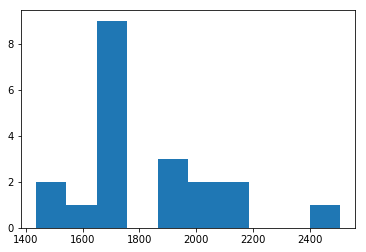

In [37]:
plt.hist(path_lengths)

#### 2. Change the number of cities in the final map (between 10 and 30).  How are your results affected?  Why?

- n = 10
    - runtime: 1.44
    - intial path: 3074
    - final path: 1822
- n = 20
    - runtime:5.48
    - intial path: 5866.82
    - final path: 3886.03
- n = 30
    - runtime:12.51
    - intial path: 8119.82
    - final path: 6053.16
- as number of cities increases, the time increases largely. tsp problem is np-hard, and run time increases almost exponentially with the size of the input. 
- the solver also reduces the final path, but the decrease seems more desirable when the total intial path is low (with fewer nodes). as the node number increases, and total length increases, the longer run time makes the reduction of total path less attractive. 

#### 3. Change the alpha and temperature parameters.  How do they affect the results?

- n = 10, initial path 3074
- alpha (temperature 1e6), runtime, final path: 
    - 0.99, 7.46, 1663
    - 0.97, 2.44. 1964 
    - 0.95, 1.44, 2096
    - 0.90, 0.72, 1835
    - 0.80, 0.34, 1665
    - 0.50, 0.12, 2167
    - 0.10, 0.04, 2439
- temperature (alpha 0.95), runtime, final path: 
    - 1e9, 1.72, 2152
    - 1e8, 1.63, 1742
    - 1e7, 1.54, 2209
    - 1e6, 1.44, 1822
    - 1e5, 1.38, 1498
    - 1e4, 1.28, 2292
    - 1e3, 1.18, 1659
- as alpha increases, run time increases drastically, this is because alpha and time are exponentially related. a small change in alpha can result in a large change in T and iterations. 
- as temperature increases, the run time increases slightly, due to the linear relationship between T and T0. 
- final shortest path seems to be affected by alpha, which determines how fast the annealing occurs. Larger alpha has slower annealing process and has more itermediate temperature, thus more sensitive. However, due to the stochastic probability process of the annealing algorithm, small alpha sometimes can also generate a good result, such as in the case of 0.8. 
- intial tempetaure does not seem to affect the final path that much. 

#### 4. Use a different schedule function (something other than exponential decay).  Is the algorithm still effective?

In [24]:
def linear_schedule(time):
    return temperature - alpha * time 

def quadratic_schedule(time):
    return temperature - alpha * time ** 2

For n = 10, alpha 0.95 run time: 
- temperature 1e3
    - exponential schedule: 1.18, 1659
    - linear schedule: 2.11, 1855
    - quadratic schedule: 0.07, 2899
- temperature 1e5
    - exponential schedule: 1.36, 1686
    - linear schedule: > 60s
    - quadratic schedule: 0.66, 2866
- temperature 1e6
    - exponential schedule: 1.44, 1822
    - linear schedule: > 60s
    - quadratic schedule: 2.06, 2911
- linear schedule decays very slow. quadratic seems to have shorter run time, but does not perform well in finding a good path. both decay functions are not as effective as the exponential decay function. 

#### 5. Use a different successors function; e.g., generate successors of a state by swapping _any_ pair of cities in the path, rather than only adjacent cities. What effect does the change have?

In [29]:
# change successor to any_successors in simulated annealing function
path_lengths = []
for i in range(20):
    result = simulated_annealing(capitals_tsp, schedule)
    path_lengths.append(-result.get_value())
    
print ("Average final path length is ", np.mean(path_lengths))
print ("Minimal final path length is ", np.min(path_lengths))
print ("Maximal final path length is ", np.max(path_lengths))

Average final path length is  1450.17396336
Minimal final path length is  1426.741597
Maximal final path length is  1498.37129105


(array([ 6.,  8.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  3.]),
 array([ 1426.741597  ,  1433.90456641,  1441.06753581,  1448.23050522,
         1455.39347462,  1462.55644403,  1469.71941343,  1476.88238284,
         1484.04535224,  1491.20832165,  1498.37129105]),
 <a list of 10 Patch objects>)

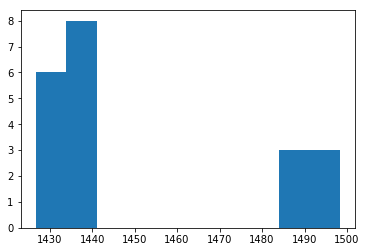

In [30]:
plt.hist(path_lengths)

alpha 0.95, temperature 1e6. 
- neighbor pair: runtime 1.42, path 1822
- any pair: runtime 6.19, path 1426
- swapping any pair largely increases the run time, but provides much stable results and lower path.
- it seems swapping any pair is a better successor function, although the run time is higher. 

#### 6. Use a different distance metric for get_value (e.g., we used the L2-norm (Euclidean distance), try the L1-norm (manhattan distance)

- euclidean_distance: 1.48s, initial path 3074
    - Average final path length is  1822.04257014
    - Minimal final path length is  1434.51542956
    - Maximal final path length is  2507.23387555
- manhattan_distance: 1.44s, initial path 3777
    - Average final path length is  2190.32
    - Minimal final path length is  1641.6
    - Maximal final path length is  3069.6
- two distance metrics have similar run time. The straight line distance provided by euclidean distancce is always no longer than the manhattan due to the triangle inequality. 
- the shortest path found does not seem to be largely affected on the distance function 

In [41]:
# change distance in the TSP to manhattan distance
path_lengths = []
for i in range(20):
    result = simulated_annealing(capitals_tsp, schedule)
    path_lengths.append(-result.get_value())
    
print ("Average final path length is ", np.mean(path_lengths))
print ("Minimal final path length is ", np.min(path_lengths))
print ("Maximal final path length is ", np.max(path_lengths))

Average final path length is  2190.32
Minimal final path length is  1641.6
Maximal final path length is  3069.6


(array([ 2.,  1.,  0.,  2.,  1.,  4.,  4.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  1.,  0.,  0.,  0.,  2.]),
 array([ 1641.6,  1713. ,  1784.4,  1855.8,  1927.2,  1998.6,  2070. ,
         2141.4,  2212.8,  2284.2,  2355.6,  2427. ,  2498.4,  2569.8,
         2641.2,  2712.6,  2784. ,  2855.4,  2926.8,  2998.2,  3069.6]),
 <a list of 20 Patch objects>)

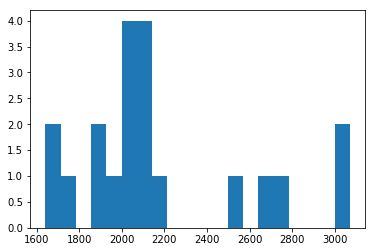

In [42]:
plt.hist(path_lengths,bins = 20)